In [1]:
!pip install captum torchinfo
!pip install scikit-image -U

     |████████████████████████████████| 1.4 MB 529 kB/s            
     |████████████████████████████████| 13.5 MB 534 kB/s            
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.1
    Uninstalling scikit-image-0.19.1:
      Successfully uninstalled scikit-image-0.19.1


In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd 
import pickle
import shutil
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Compose, ToTensor,Normalize, Resize


import_model = False

## Data preprocessing
Copy train and test data to torch format
### Train data

In [3]:
labels_dict = {'file':[], 'c':[]}
dest_fpath = '/kaggle/working/train/img/'

os.makedirs(os.path.dirname(dest_fpath), exist_ok=True)

for dirname, _, filenames in os.walk('/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA'):
    for filename in filenames:
        labels_dict['file'] += [filename]
        labels_dict['c'] += [int(filename.split('_')[0])]
for dirname, _, filenames in os.walk('/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA'):
    for filename in filenames:
        shutil.copy(dirname + '/' + filename, dest_fpath + filename)
labels = pd.DataFrame(labels_dict)
labels.to_csv('train/annotations.csv', header=False, index=False)

In [4]:
!ls train; ls train/img | wc

annotations.csv  img
   4170    4170   58830


In [5]:
len(pd.unique(labels['file']))

4170

In [6]:
n_classes = len(pd.unique(labels['c']))

### Test data

In [7]:
labels_dict_test = {'file':[], 'c':[]}
dest_fpath_test = '/kaggle/working/test/img/'

os.makedirs(os.path.dirname(dest_fpath_test), exist_ok=True)

for dirname, _, filenames in os.walk('/kaggle/input/traffic-sign-dataset-classification/traffic_Data/TEST'):
    for filename in filenames:
        labels_dict_test['file'] += [filename]
        labels_dict_test['c'] += [int(filename.split('_')[0])]
labels_test = pd.DataFrame(labels_dict_test)
labels_test.to_csv('test/annotations.csv', header=False, index=False)

for dirname, _, filenames in os.walk('/kaggle/input/traffic-sign-dataset-classification/traffic_Data/TEST'):
    for filename in filenames:
        shutil.copy(dirname + '/' + filename, dest_fpath_test + filename)

In [8]:
!ls test; ls test/img | wc

annotations.csv  img
   1994    1994   33094


In [9]:
len(pd.unique(labels_test['file']))

1994

### Class labels

In [10]:
class_labels = pd.read_csv('/kaggle/input/traffic-sign-dataset-classification/labels.csv')
class_labels.head()

ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)

In [11]:
def predicted_class(observation):
    img = observation[0]
    pred_number = model_ft(img.reshape(1,3,224,224).to(device)).argmax(1).type(torch.int).item()
    return class_labels.loc[pred_number, 'Name']

def labeled_class(observation):
    number = observation[1]
    return class_labels.loc[number, 'Name']

def show_photo(observation):
    data = observation[0].permute(1,2,0).numpy()
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Torch dataset

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        image = image / 255
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
preprocess = Compose([
    Resize((224, 224))
])

In [14]:
!ls ../input/pd3-2022l-wb

__notebook__.ipynb  __results__.html   custom.css  test
__output__.json     __results___files  model	   train


In [15]:
train_dataset = CustomImageDataset('../input/pd3-2022l-wb/train/annotations.csv', '../input/pd3-2022l-wb/train/img/', transform=preprocess)
test_dataset = CustomImageDataset('../input/pd3-2022l-wb/test/annotations.csv', '../input/pd3-2022l-wb/test/img/', transform=preprocess)

In [16]:
len(train_dataset)

4169

In [17]:
len(test_dataset)

1993

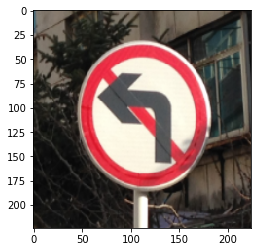

'Dont Go Left'

In [18]:
img = train_dataset[3548]
show_photo(img)
labeled_class(img)

## Torch dataloader

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

## Resnet-18

In [20]:
if not import_model:
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc=nn.Linear(512, n_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_ft = resnet18.to(device)
    params_to_update = model_ft.parameters()
    optimizer = optim.AdamW(params_to_update, lr=0.001, weight_decay=0.25)
    criterion = nn.CrossEntropyLoss()
    n_epoch = 20

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Weight decay was added to prevent overfitting

In [21]:
if not import_model:
    train_results = []
    test_results = []
    for epoch in range(n_epoch):
        print('Epoch {}/{}'.format(epoch + 1, n_epoch))
        print('-' * 10)

        model_ft.train()
        train_loss = 0
        train_correct = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            loss.backward()
            optimizer.step()

        model_ft.eval()
        test_loss = 0
        test_correct = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            batch_loss = criterion(outputs, labels).item()
            with torch.no_grad():
                test_loss += batch_loss
                test_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

        test_acc = test_correct / len(test_dataset)
        train_acc = train_correct / len(train_dataset)
        train_results += [{'loss': train_loss, 'acc': train_acc}]
        test_results += [{'loss': test_loss, 'acc':test_acc}]

Epoch 1/20
----------
Epoch 2/20
----------
Epoch 3/20
----------
Epoch 4/20
----------
Epoch 5/20
----------
Epoch 6/20
----------
Epoch 7/20
----------
Epoch 8/20
----------
Epoch 9/20
----------
Epoch 10/20
----------
Epoch 11/20
----------
Epoch 12/20
----------
Epoch 13/20
----------
Epoch 14/20
----------
Epoch 15/20
----------
Epoch 16/20
----------
Epoch 17/20
----------
Epoch 18/20
----------
Epoch 19/20
----------
Epoch 20/20
----------


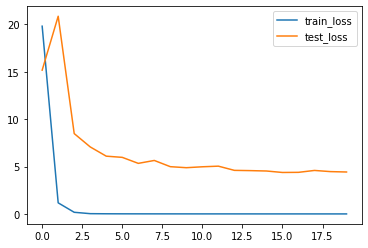

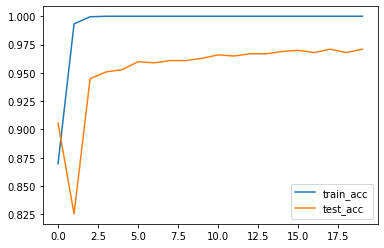

In [22]:
if not import_model:
    train_df = pd.DataFrame(train_results)
    train_df.columns = ['train_' + col for col in train_df.columns]
    test_df = pd.DataFrame(test_results)
    test_df.columns = ['test_' + col for col in test_df.columns]

    pd.concat([train_df, test_df], axis=1).loc[:,['train_loss', 'test_loss']].plot()
    pd.concat([train_df, test_df], axis=1).loc[:,['train_acc', 'test_acc']].plot()

### Save model for the future

In [23]:
if not import_model:
    with open("/kaggle/working/model","wb") as f:
        pickle.dump(model_ft, f)

In [24]:
if import_model:
    with open("../input/pd3-2022l-wb/model","rb") as f:
        model_ft = pickle.load(f)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Explanations

In [25]:
import captum
from captum.attr import Lime, GradientShap, DeepLiftShap, GuidedBackprop, IntegratedGradients, InputXGradient, visualization
from skimage import segmentation

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

In [26]:
observation_idx = [32, 33, 343, 363, 763, 774]

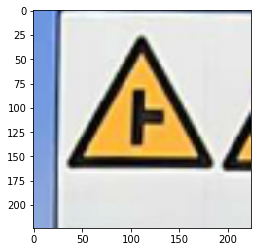

Go right or straight


'Go right or straight'

In [27]:
img = test_dataset[777]
show_photo(img)
print(labeled_class(img))
predicted_class(img)

In [28]:
def generate_masks(observation):
    slic_masks = [
        segmentation.slic(
            test_dataset[observation][0].permute(1, 2, 0).mean(axis=2), 
            n_segments=50, 
            compactness=0.5, 
            start_label=0
          ),
        segmentation.slic(
            test_dataset[observation][0].permute(1, 2, 0).mean(axis=2), 
            n_segments=50, 
            compactness=0.05, 
            start_label=0
          ),
        segmentation.slic(
            test_dataset[observation][0].permute(1, 2, 0).mean(axis=2), 
            n_segments=12, 
            compactness=0.1, 
            start_label=0
          ),
    ]
    qs_masks = [
        segmentation.quickshift(
            test_dataset[observation][0].permute(1, 2, 0), 
            kernel_size=14, 
            max_dist=7, 
            ratio=0.5
          ),
        segmentation.quickshift(
            test_dataset[observation][0].permute(1, 2, 0), 
            kernel_size=6, 
            max_dist=7, 
            ratio=0.1
          ),
        segmentation.quickshift(
            test_dataset[observation][0].permute(1, 2, 0), 
            kernel_size=6, 
            max_dist=3, 
            ratio=0.4
          ),
    ]
    return slic_masks + qs_masks


def show_lime_explanations(observation, explainer):
    masks = generate_masks(observation)
    image = test_dataset[observation]
    mask_params = [
        'silc, n=50, compactness=0.5',
        'silc, n=50, compactness=0.05',
        'silc, n=12, compactness=0.1',
        'qs, kernel_size=14, max_dist=7, ratio=0.5',
        'qs, kernel_size=6, max_dist=7, ratio=0.1',
        'qs, kernel_size=6, max_dist=3, ratio=0.4'
    ]
    attrs = []
    for mask in masks:
        attrs += [explainer.attribute(
            preprocess(image[0].unsqueeze(0)).to(device), 
            target=torch.as_tensor(image[1]).to(device), 
            n_samples=200, 
            feature_mask=torch.as_tensor(mask).to(device),
            show_progress=True
          )]
    print('Label:', labeled_class(image))
    print('Prediction: ',predicted_class(image))
    fig, ax = plt.subplots(7, 2, figsize=[6 * 2, 6 * 7])
    ax[0][0].imshow(image[0].permute(1, 2, 0))
    ax[0][0].set_title("image")
    for idx, (mask, attr, mask_param) in enumerate(zip(masks, attrs, mask_params)):
        ax[idx+1][0].imshow(mask, cmap="flag")
        ax[idx+1][0].set_title(mask_param)
        ax[idx+1][1].imshow(attr[0].cpu().mean(axis=0), vmin=-1, vmax=1, cmap="RdBu")
        ax[idx+1][1].set_title("explanation")
    plt.show()

### Lime explanations with different masks

Lime attribution: 100%|██████████| 200/200 [00:01<00:00, 184.22it/s]


Label: No stopping
Prediction:  No stopping


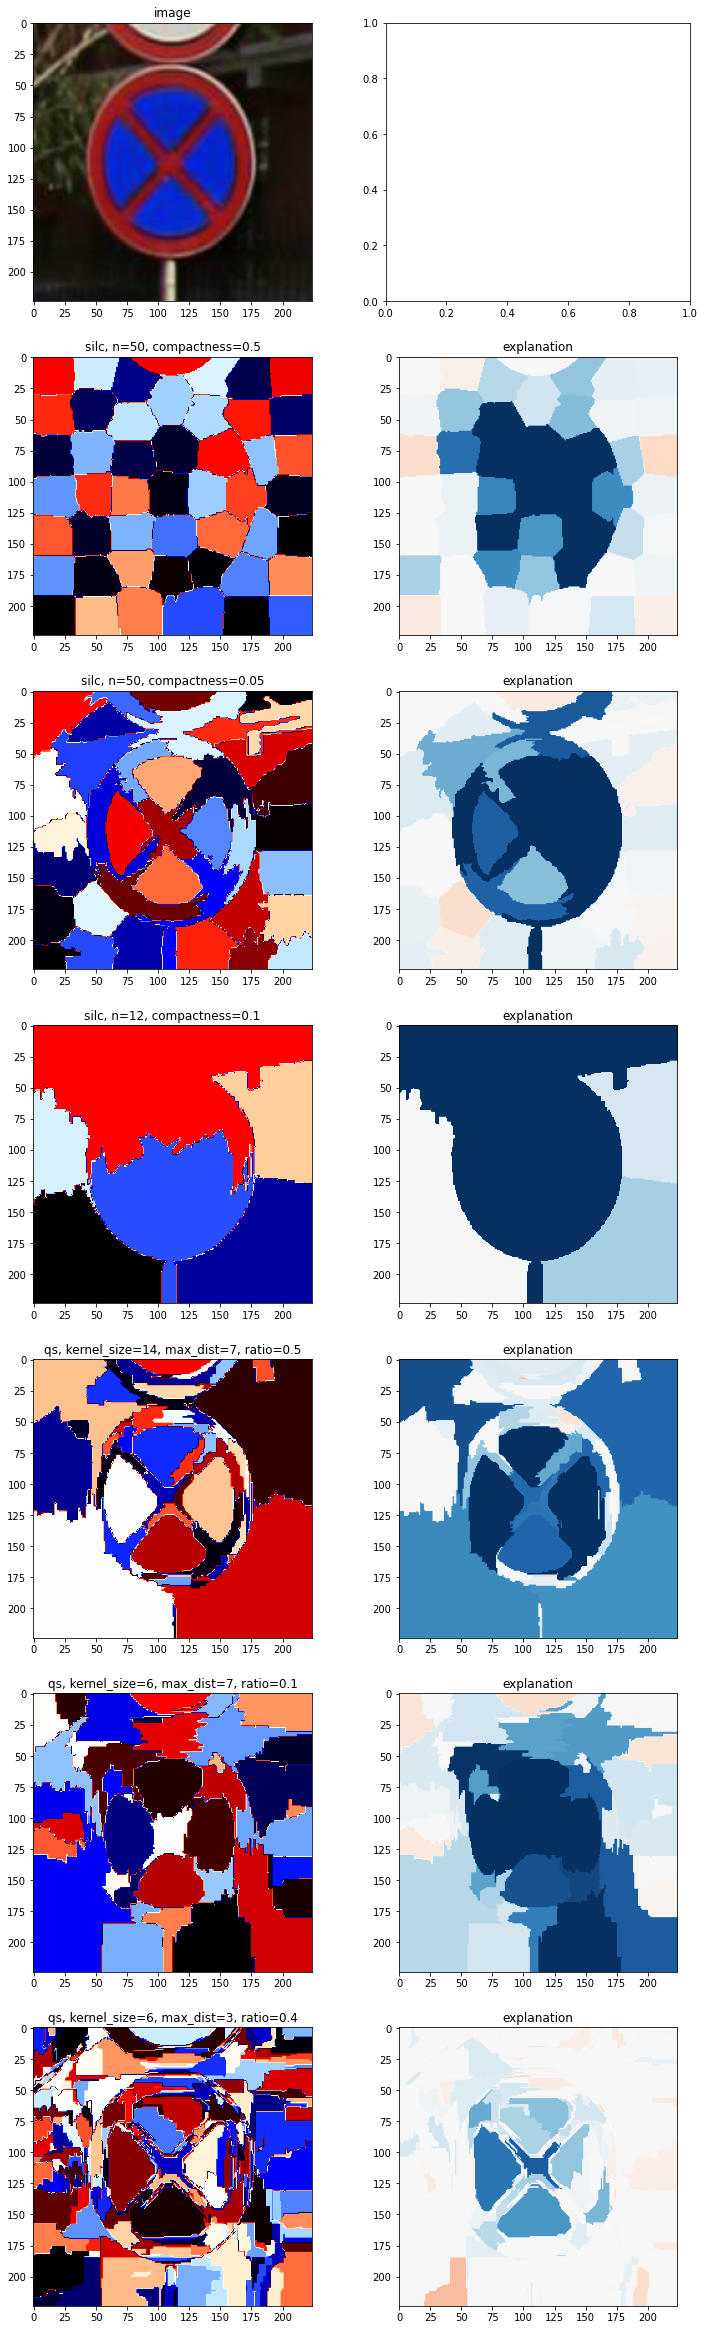

Lime attribution: 100%|██████████| 200/200 [00:01<00:00, 187.88it/s]


Label: Train Crossing
Prediction:  Train Crossing


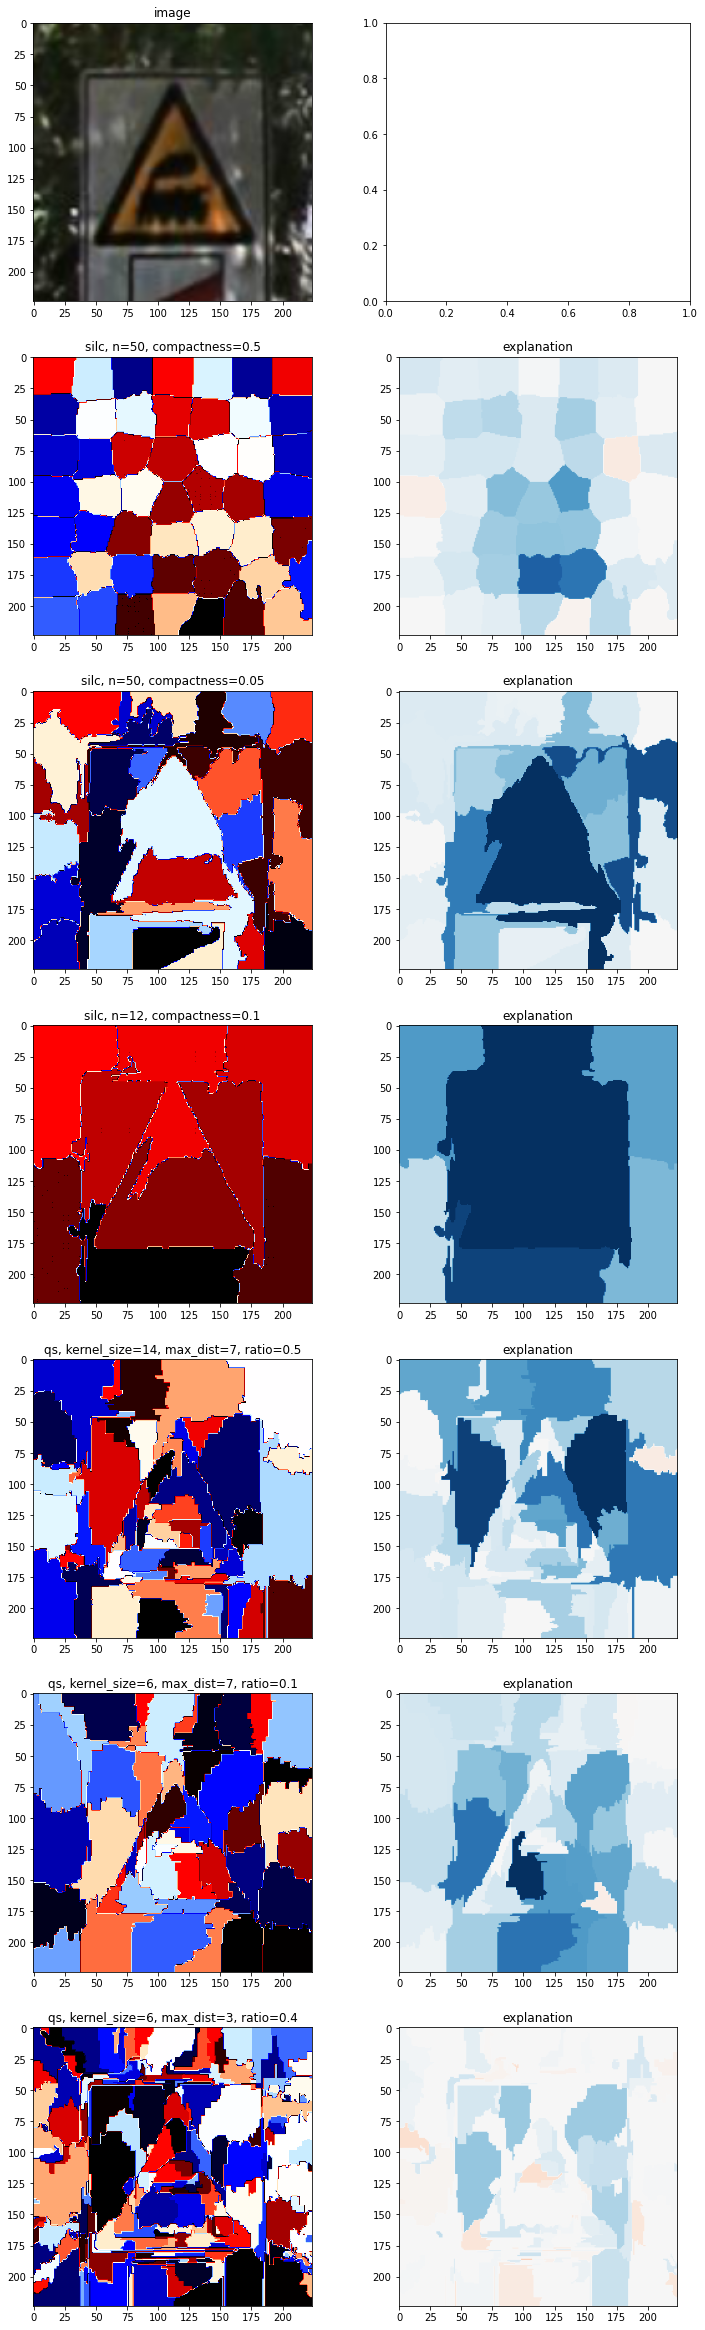

Lime attribution: 100%|██████████| 200/200 [00:01<00:00, 142.83it/s]


Label: Dont Go Left
Prediction:  Dont Go Left


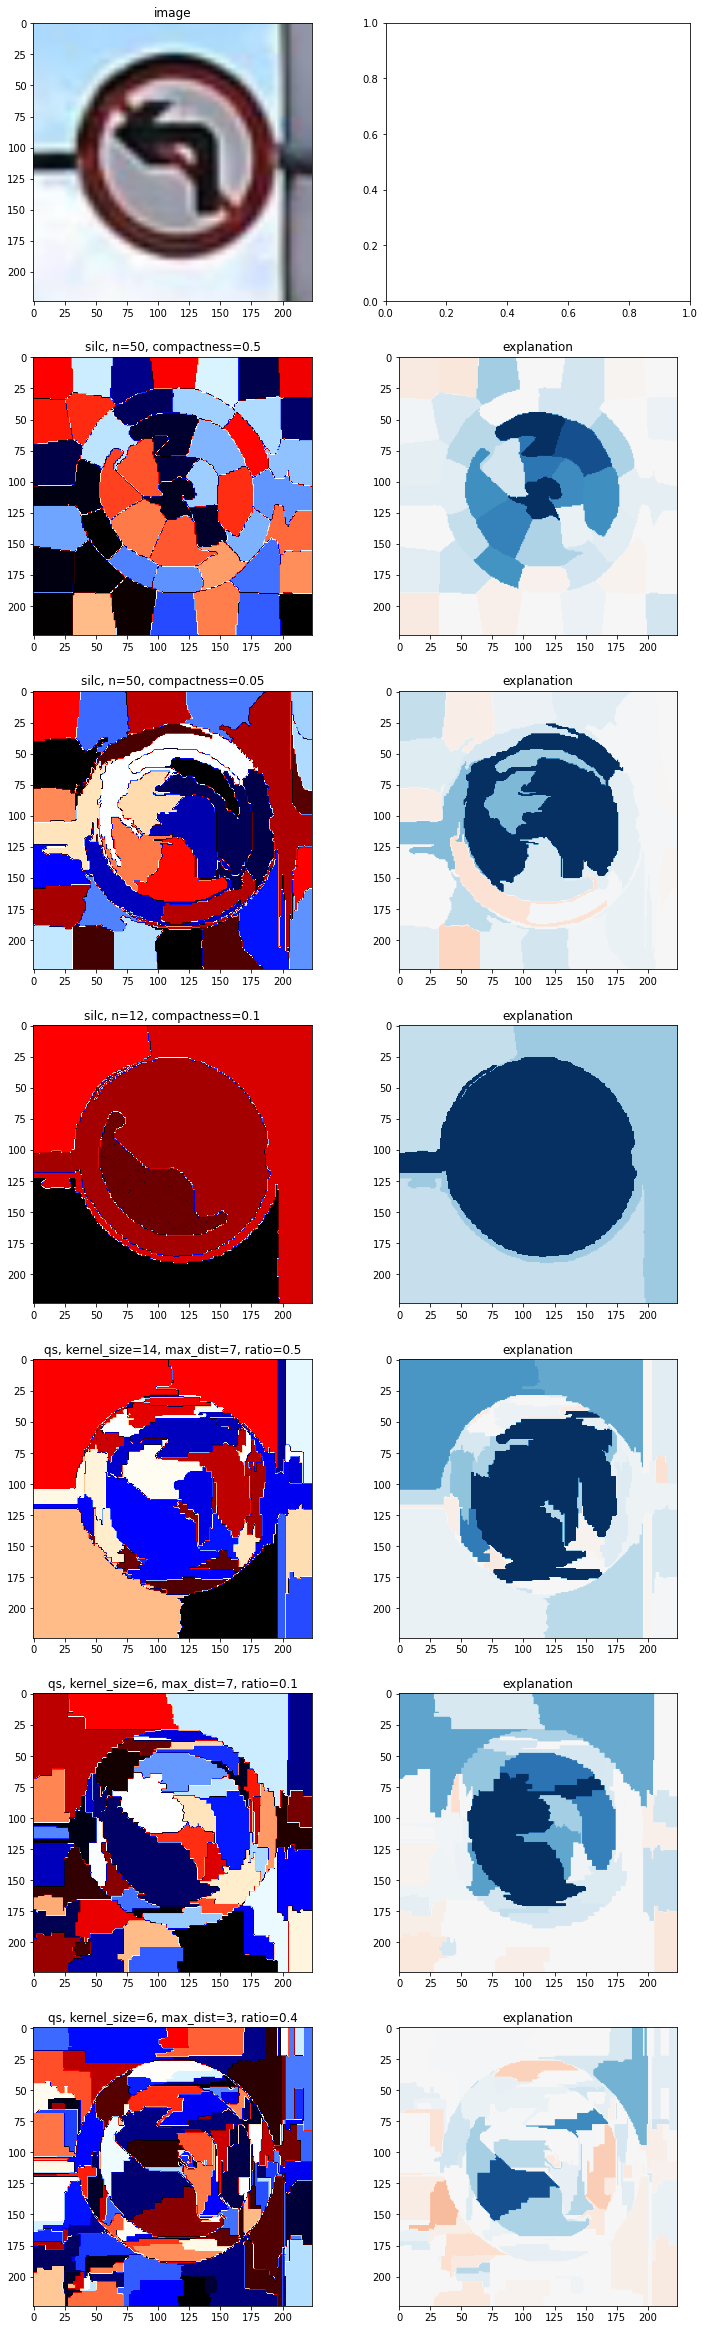

Lime attribution: 100%|██████████| 200/200 [00:01<00:00, 182.83it/s]


Label: Go left or straight
Prediction:  Go left or straight


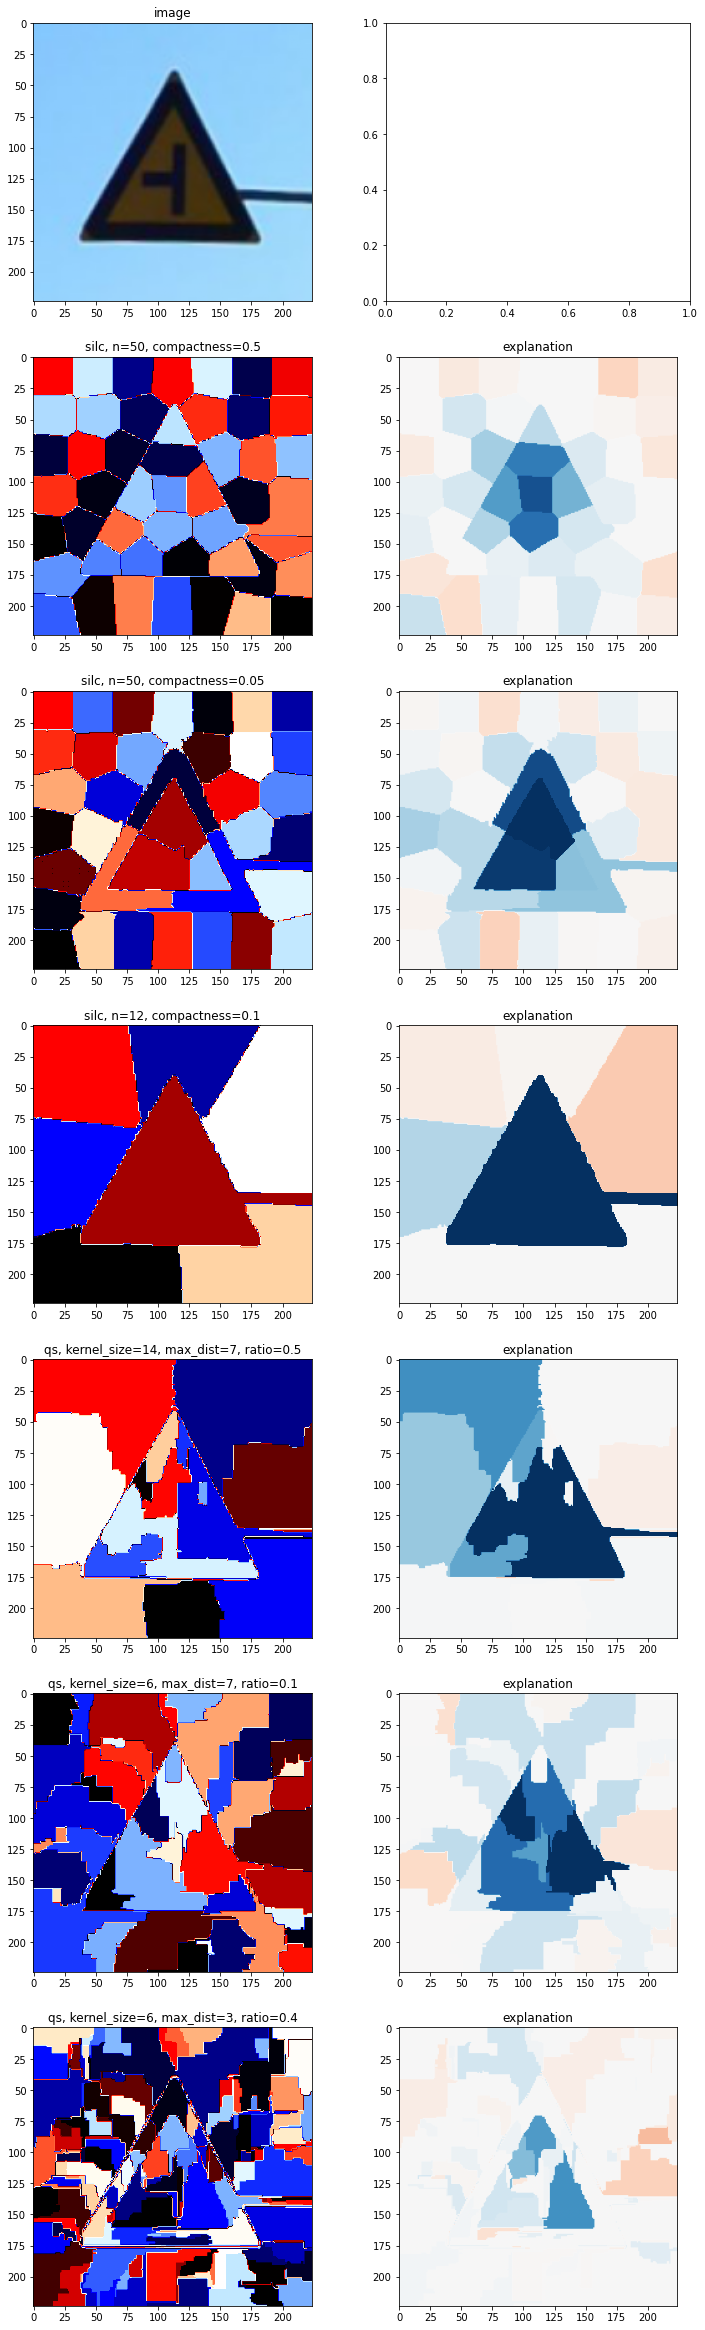

Lime attribution: 100%|██████████| 200/200 [00:01<00:00, 182.48it/s]


Label: No Car
Prediction:  No Car


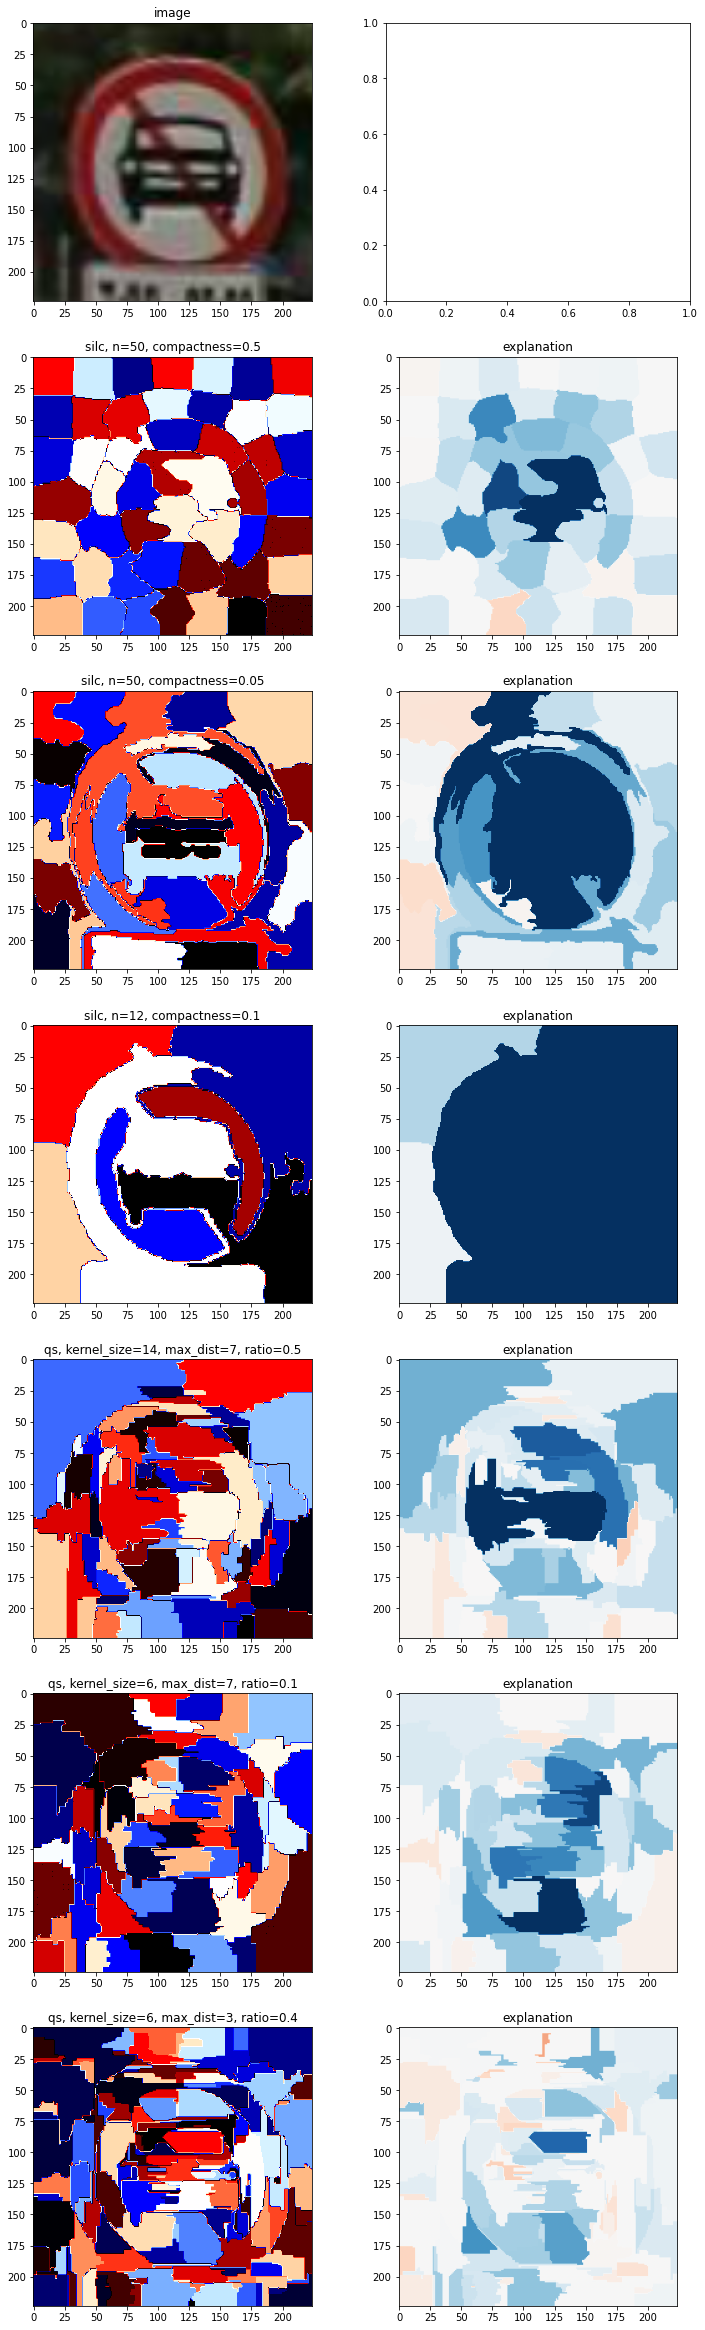

Lime attribution: 100%|██████████| 200/200 [00:01<00:00, 180.79it/s]


Label: Unknown6
Prediction:  Unknown6


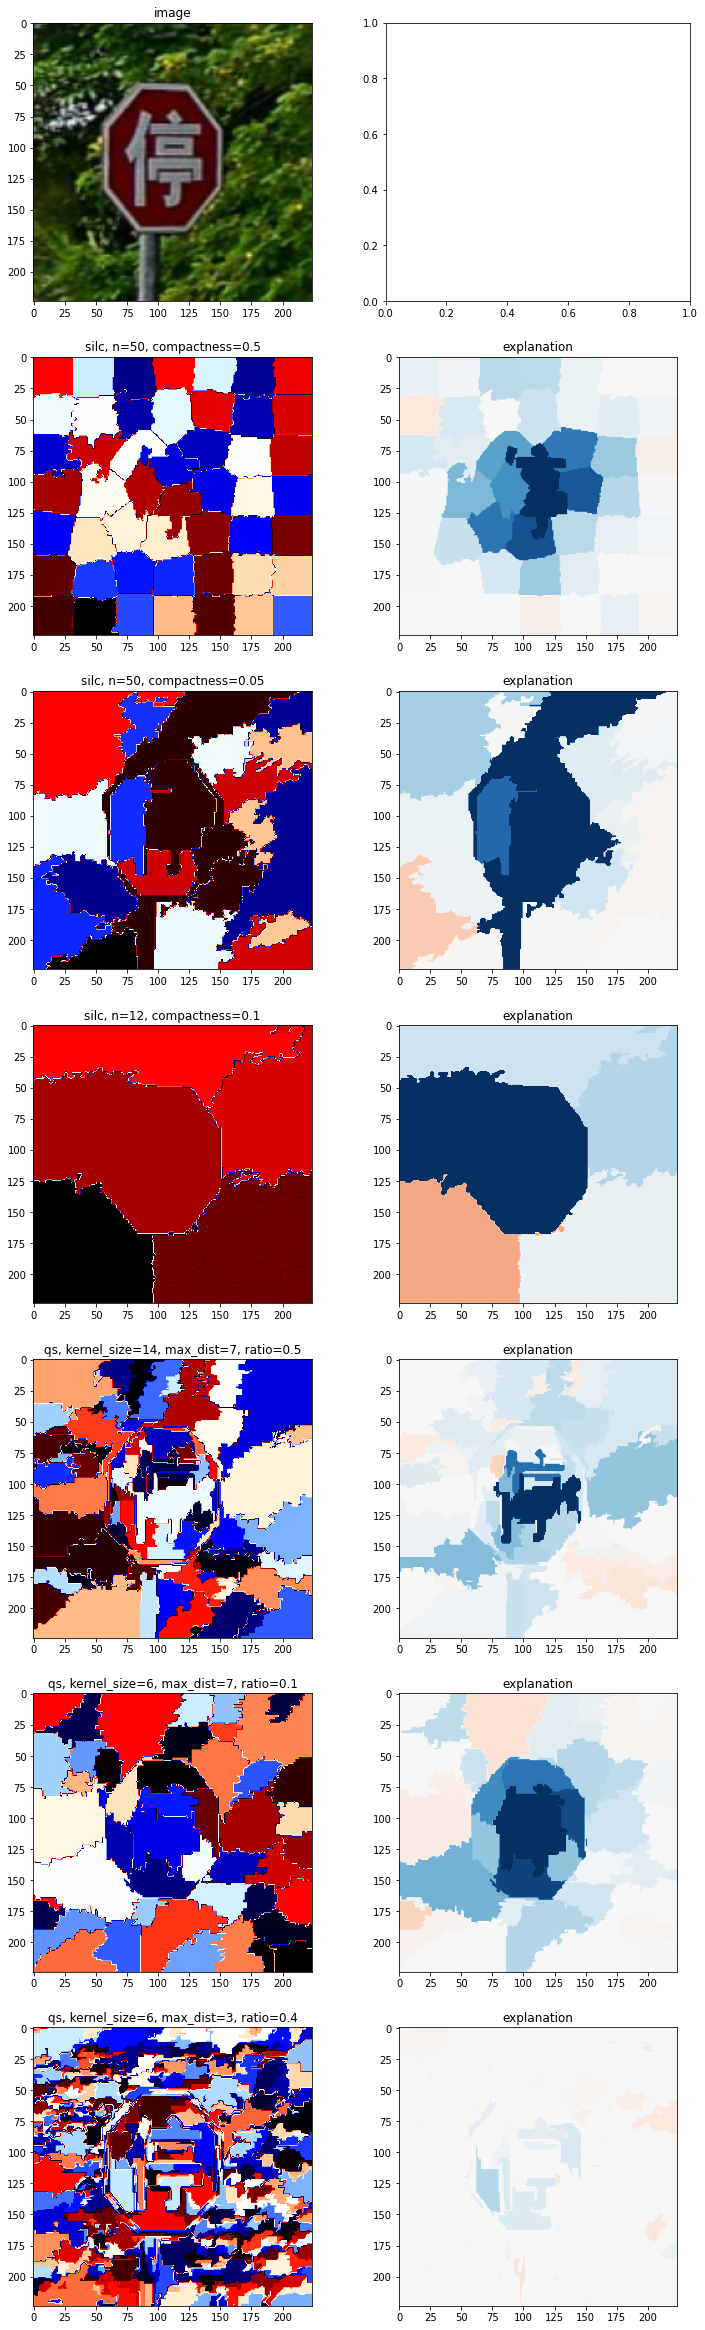

In [29]:
explainer = Lime(model_ft)
for observation in observation_idx:
    show_lime_explanations(observation, explainer)

Best results are obtainded with segmentation algorithms:
* silc (n=50, compactness=0.05),  
* quickshift (kernel_size=6, max_dist=7, ratio=0.1),
* quickshift (kernel_size=14, max_dist=7, ratio=0.5)

Explanations, that used these masks, show bigger attribuiton of superpixels representing signs. Generally they provide satysfing results.



## Missclassified

First, get the missclassified observations from test set.

In [30]:
missed_idx = []
for idx, observation in enumerate(test_dataset):
    if labeled_class(observation) != predicted_class(observation):
        missed_idx += [idx]

In [31]:
print(len(missed_idx))
1 - len(missed_idx) / len(test_dataset)

56


0.9719016557952835

All missed predictions with images and labels:

0
Label: Dont Go Right
Prediction:  Dont Go Left or Right


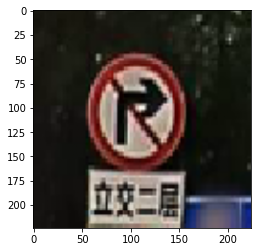

1
Label: Speed limit (40km/h)
Prediction:  No Uturn


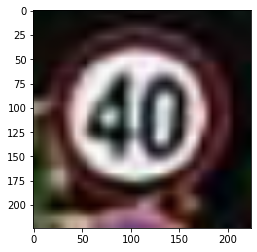

2
Label: Go Left or right
Prediction:  Go straight or right


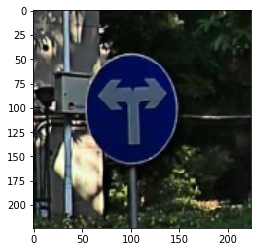

3
Label: keep Right
Prediction:  Road Divider


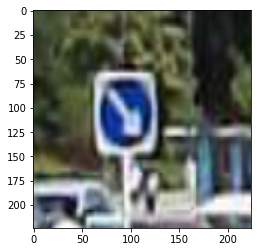

4
Label: Dont Go Right
Prediction:  Dont Go Left or Right


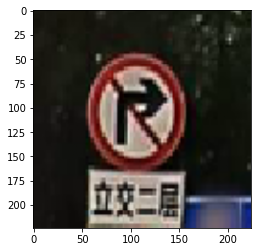

5
Label: speed limit (80km/h)
Prediction:  Speed limit (50km/h)


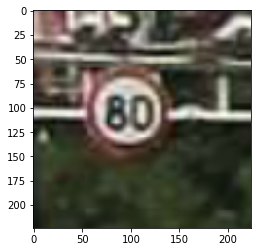

6
Label: Unknown7
Prediction:  Train Crossing


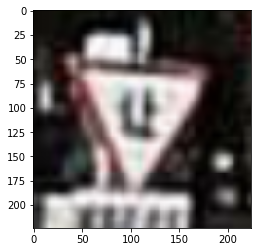

7
Label: Dont Go Right
Prediction:  Dont Go Left or Right


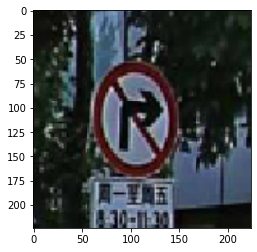

8
Label: No stopping
Prediction:  keep Left


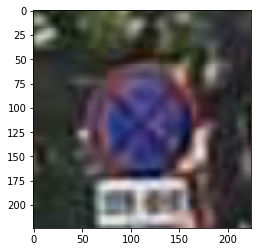

9
Label: No Uturn
Prediction:  Uturn


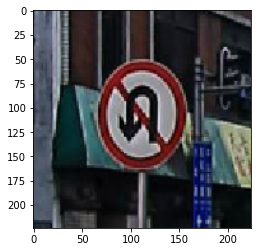

10
Label: Bicycles crossing
Prediction:  Horn


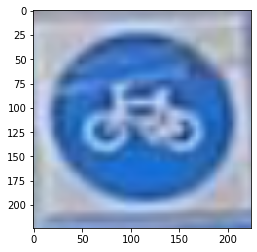

11
Label: Speed limit (5km/h)
Prediction:  Speed limit (50km/h)


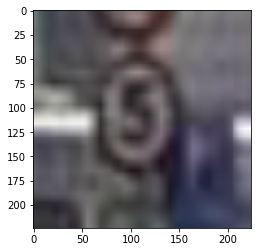

12
Label: No horn
Prediction:  Speed limit (50km/h)


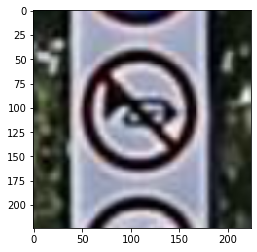

13
Label: Go Left or right
Prediction:  Go straight or right


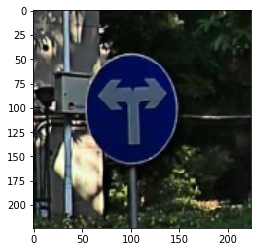

14
Label: Speed limit (40km/h)
Prediction:  No Uturn


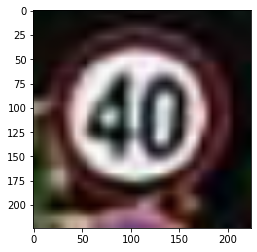

15
Label: Bicycles crossing
Prediction:  Roundabout mandatory


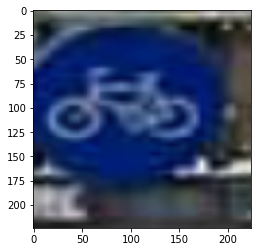

16
Label: Bicycles crossing
Prediction:  Roundabout mandatory


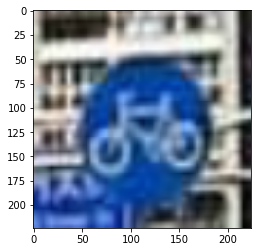

17
Label: Dont Go Right
Prediction:  Dont Go Left or Right


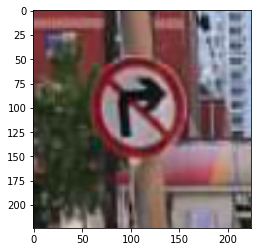

18
Label: Go Left or right
Prediction:  Go straight or right


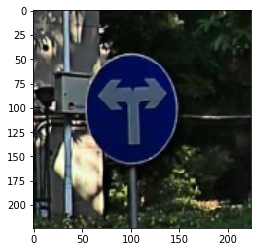

19
Label: Dont Go Right
Prediction:  Dont Go Left or Right


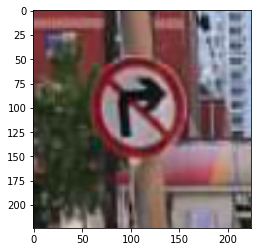

20
Label: speed limit (80km/h)
Prediction:  Speed limit (60km/h)


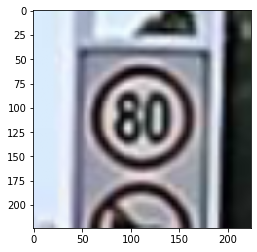

21
Label: Dont Go Right
Prediction:  Dont Go Left or Right


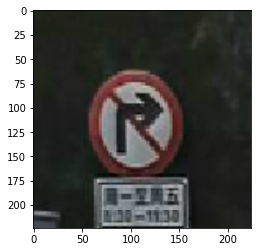

22
Label: No stopping
Prediction:  keep Left


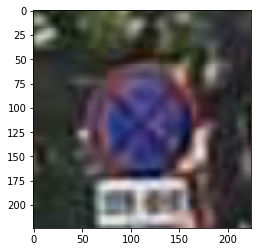

23
Label: Speed limit (15km/h)
Prediction:  No Car


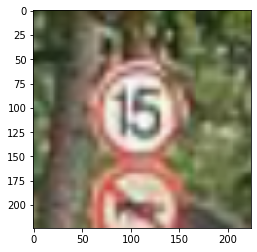

24
Label: Dont Go Right
Prediction:  Dont Go Left or Right


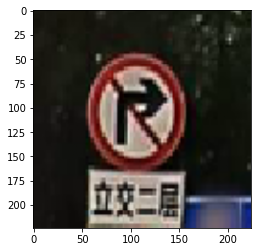

25
Label: Dont Go Right
Prediction:  Dont Go Left or Right


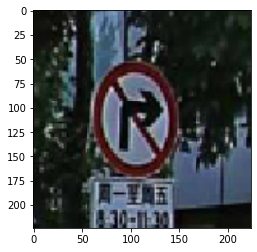

26
Label: Bicycles crossing
Prediction:  Horn


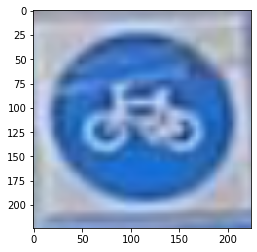

27
Label: Bicycles crossing
Prediction:  Roundabout mandatory


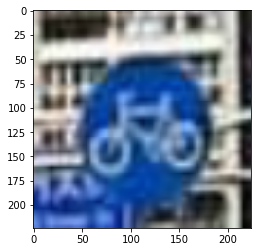

28
Label: keep Right
Prediction:  Road Divider


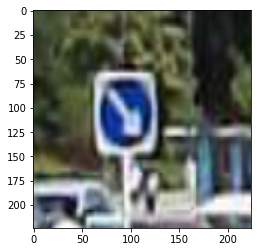

29
Label: Dont Go Right
Prediction:  Dont Go Left or Right


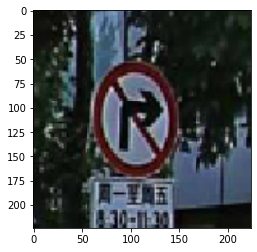

30
Label: Unknown7
Prediction:  Train Crossing


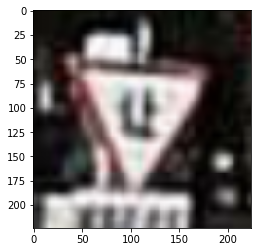

31
Label: Dangerous curve to the left
Prediction:  ZigZag Curve


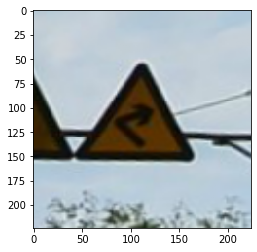

32
Label: Bicycles crossing
Prediction:  Roundabout mandatory


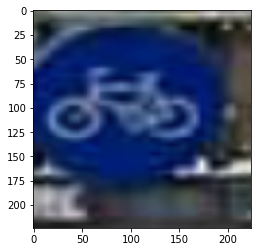

33
Label: speed limit (80km/h)
Prediction:  Speed limit (60km/h)


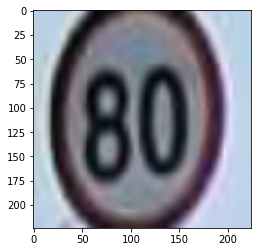

34
Label: keep Right
Prediction:  Uturn


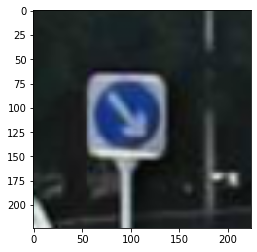

35
Label: No Uturn
Prediction:  Uturn


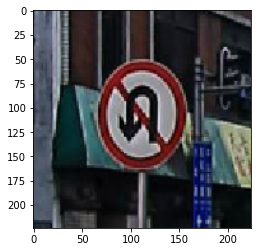

36
Label: Bicycles crossing
Prediction:  Go straight


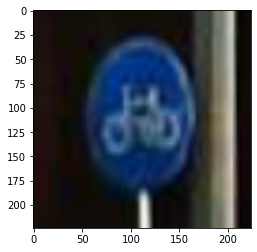

37
Label: Go Left or right
Prediction:  Go straight or right


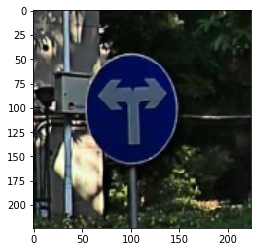

38
Label: Dont Go Right
Prediction:  Dont Go Left or Right


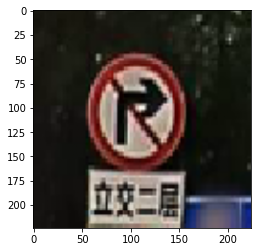

39
Label: Dont Go Right
Prediction:  Dont Go Left or Right


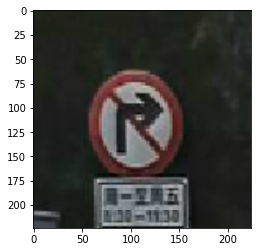

40
Label: Dangerous curve to the left
Prediction:  ZigZag Curve


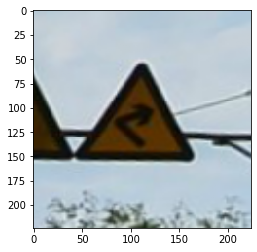

41
Label: speed limit (80km/h)
Prediction:  Speed limit (60km/h)


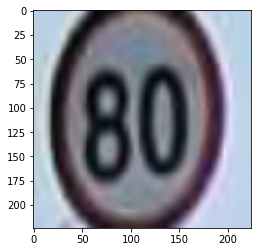

42
Label: No Uturn
Prediction:  Uturn


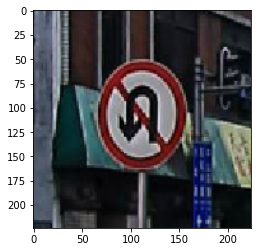

43
Label: Speed limit (5km/h)
Prediction:  Speed limit (50km/h)


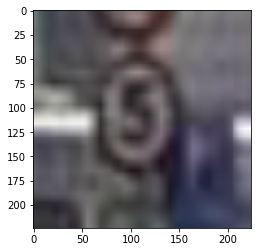

44
Label: speed limit (80km/h)
Prediction:  Speed limit (50km/h)


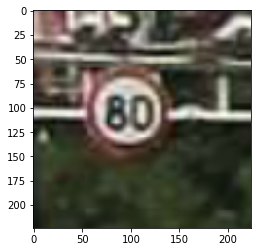

45
Label: No Uturn
Prediction:  Speed limit (30km/h)


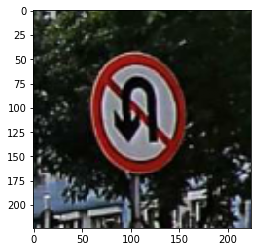

46
Label: keep Right
Prediction:  Uturn


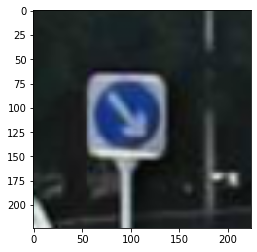

47
Label: No Uturn
Prediction:  Speed limit (30km/h)


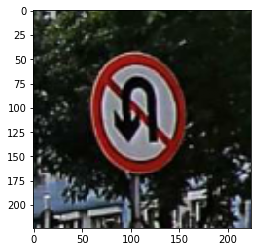

48
Label: Speed limit (15km/h)
Prediction:  No Car


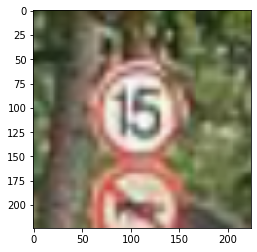

49
Label: No horn
Prediction:  Speed limit (50km/h)


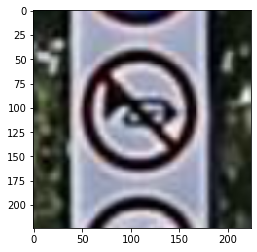

50
Label: Bicycles crossing
Prediction:  Go straight


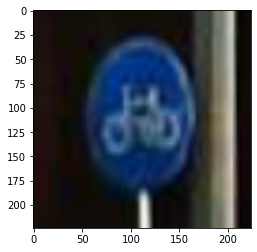

51
Label: Dont Go Right
Prediction:  Dont Go Left or Right


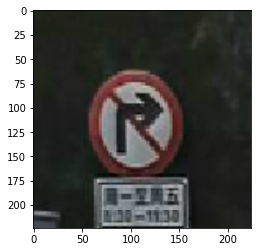

52
Label: Dont Go Right
Prediction:  Dont Go Left or Right


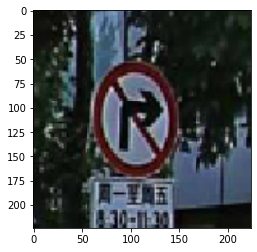

53
Label: No Uturn
Prediction:  Uturn


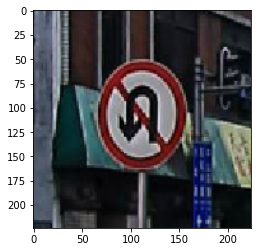

54
Label: Dont Go Right
Prediction:  Dont Go Left or Right


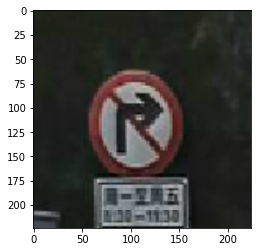

55
Label: speed limit (80km/h)
Prediction:  Speed limit (60km/h)


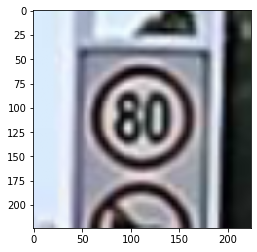

In [32]:
for (no,m_idx) in enumerate(missed_idx):
    image = test_dataset[m_idx]
    print(no)
    print('Label:', labeled_class(image))
    print('Prediction: ',predicted_class(image))
    show_photo(image)

### Explanation for missed predictions

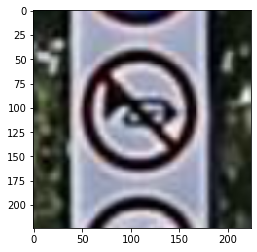

Labeled: No horn
Explanation for labeled target:


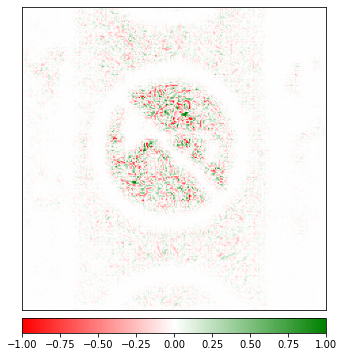

Predicted: Speed limit (50km/h)
Explanation for predicted target:


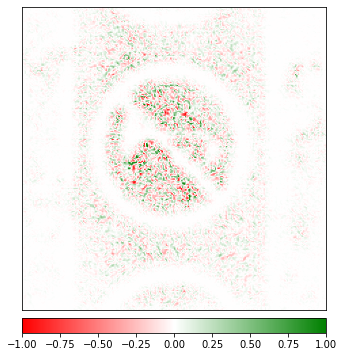

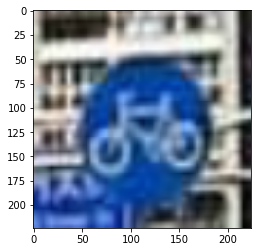

Labeled: Bicycles crossing
Explanation for labeled target:


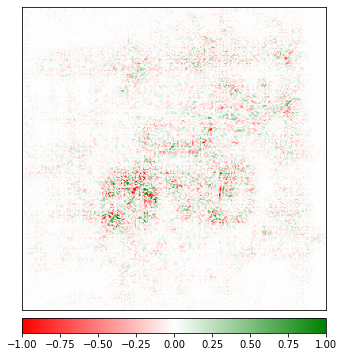

Predicted: Roundabout mandatory
Explanation for predicted target:


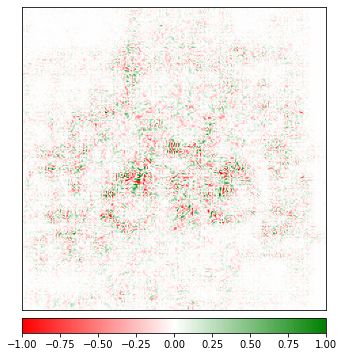

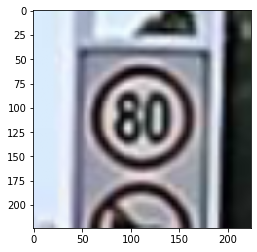

Labeled: speed limit (80km/h)
Explanation for labeled target:


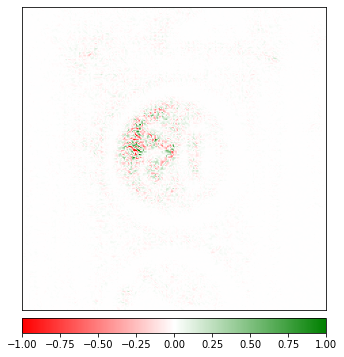

Predicted: Speed limit (60km/h)
Explanation for predicted target:


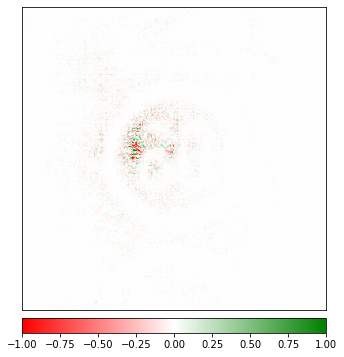

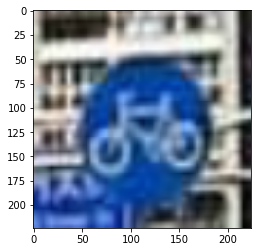

Labeled: Bicycles crossing
Explanation for labeled target:


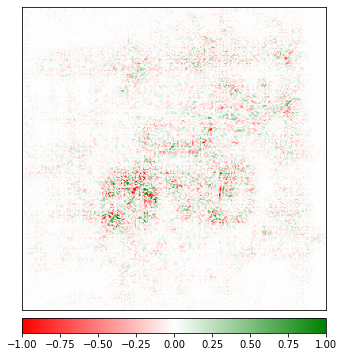

Predicted: Roundabout mandatory
Explanation for predicted target:


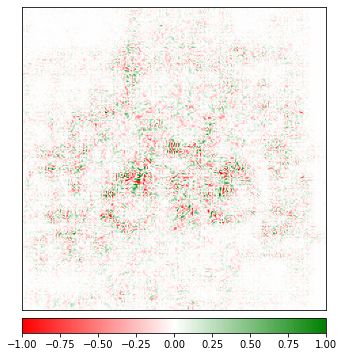

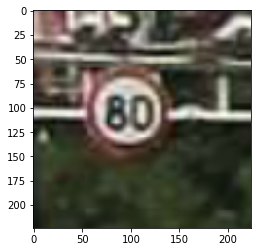

Labeled: speed limit (80km/h)
Explanation for labeled target:


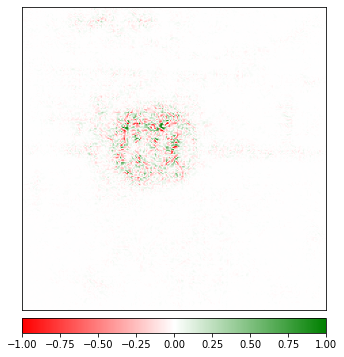

Predicted: Speed limit (50km/h)
Explanation for predicted target:


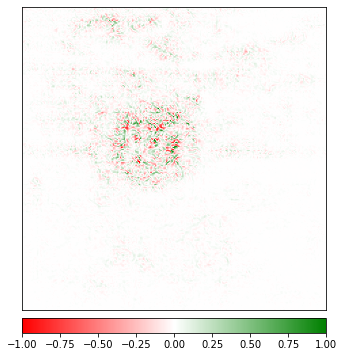

In [33]:
ig = IntegratedGradients(model_ft)
def show_ig_explanation(missed_idx):
    img = torch.as_tensor(test_dataset[missed_idx][0]).to(device)
    label = torch.as_tensor(test_dataset[missed_idx][1]).to(device)
    predicted = model_ft(img.reshape(1,3,224,224).to(device)).argmax(1).type(torch.int).item()
        
    ig_input = preprocess(img.unsqueeze(0)).to(device) 
    attr_label = ig.attribute(ig_input, target=label)
    attr_pred = ig.attribute(ig_input, target=predicted)
    
    show_photo(test_dataset[missed_idx])
    print("Labeled:", labeled_class(test_dataset[missed_idx]))
    print("Explanation for labeled target:")
    show_attr(attr_label[0].cpu().detach())
    print("Predicted:", predicted_class(test_dataset[missed_idx]))
    print("Explanation for predicted target:")
    show_attr(attr_pred[0].cpu().detach())
    
interesting_missed = [12,27, 20, 16, 5]
for i in interesting_missed:
    show_ig_explanation(missed_idx[i])

There are no visible differences in explanations with target set to label or predicted label. Most of attribution is connected to the area of the sign.